# Data Load

In [1]:
import pandas as pd

df = pd.read_csv('../NLME.csv', low_memory=False)
unique_labels = df['label'].unique()
print("Unique labels:", unique_labels)
label_counts = df['label'].value_counts()
print("Value counts:\n", label_counts)

df2 = pd.read_csv('../parsed_events (20).csv', low_memory=False)

unique_labels = df2['label'].unique()
print("Unique labels:", unique_labels)
label_counts = df2['label'].value_counts()
print("Value counts:\n", label_counts)

Unique labels: [0 1]
Value counts:
 label
0    53802
1    17215
Name: count, dtype: int64
Unique labels: [0 1]
Value counts:
 label
0    602450
1    162061
Name: count, dtype: int64


# Data Preprocess

In [2]:
df2.rename(columns={
    'target_file_name': 'TargetFilename',
    'event_id': 'EventID',
    'target_process_guid': 'TargetProcessGuid',
    'event_type': 'EventType',
    'target_image': 'TargetImage',
    'previous_creation_utc_time': 'PreviousCreationUtcTime',
    'destination_host_name': 'DestinationHostname',
    'company': 'Company',
    'description': 'Description',
    'product': 'Product',
    'integrity_level': 'IntegrityLevel',
    'creation_utc_time': 'CreationUtcTime',
    'start_function': 'StartFunction',
    'parent_process_id': 'ParentProcessGuid',
    'user': 'User',
    'logon_id': 'LogonId',
    'parent_process_id': 'ParentProcessId',
    'terminal_session_id': 'TerminalSessionId',
    'rule_name': 'RuleName',
    'target_object': 'TargetObject',
    'parent_process_guid': 'ParentProcessGuid'
    }, inplace=True)

In [3]:
important_columns = [
    'TargetFilename', 
    'EventID', 
    'TargetProcessGuid', 
    'EventType',
    'TargetImage', 
    'PreviousCreationUtcTime', 
    'DestinationHostname', 
    'Company', 
    'Description',
    'Product', 
    'IntegrityLevel', 
    'CreationUtcTime', 
    # 'StartFunction', 
    'ParentProcessGuid', 
    'User',
    'LogonId', 
    'ParentProcessId', 
    'TerminalSessionId', 
    'RuleName', 
    'TargetObject', 
    'label'
]

selected_df = df[important_columns]
selected_df2 = df2[important_columns]

## Data Split

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder

def clean_and_encode(df):
    df = df.replace('-', np.nan)
    df = df.dropna(axis=1, how='all').drop_duplicates()
    le = LabelEncoder()
    filtered = []
    for col in df.columns:
        if col == 'label':
            continue
        if df[col].nunique() <= 25 and col != 'label':
            filtered.append(col)
            mask = df[col].isnull()
            df.loc[mask, col] = -1
            df.loc[~mask, col] = le.fit_transform(df[col][~mask])
        else:
            if df[col].dtype == "object":
                df[col] = df[col].str.len()
            df[col] = df[col].fillna(-1)
    return df, filtered

def preprocess_data_3(df, df2):
    df['label'] = df['label'].replace({1: -1, 0: 1})
    df2['label'] = df2['label'].replace({1: -1, 0: 1})
    df, filteredColumn = clean_and_encode(df)
    df2, _ = clean_and_encode(df2)
    
    benign_df = df[df['label'] == 1]
    malware_df = df[df['label'] == -1]
    train_df = benign_df.iloc[malware_df.shape[0]:]
    test_df = pd.concat([benign_df.iloc[:malware_df.shape[0]], malware_df])

    benign_df2 = df2[df2['label'] == 1]
    malware_df2 = df2[df2['label'] == -1]
    
    print(filteredColumn)

    train_means = benign_df[filteredColumn].mean()
    test_means = benign_df2[filteredColumn].mean()

    abs_diff = (train_means - test_means).abs()
    df_diff = pd.DataFrame({
        "Train means": train_means,
        "Test means": test_means,
        "Diff": abs_diff
    }).sort_values(by="Diff", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.lineplot(x=range(len(filteredColumn)), y=train_means.values, label="Train Benign")
    sns.lineplot(x=range(len(filteredColumn)), y=test_means.values, label="Test Benign")
    plt.xticks(range(len(filteredColumn)), filteredColumn, rotation=90)
    plt.title("Feature Distribution Shift (Benign)")
    plt.tight_layout()
    plt.show()

    benign_shuffled = benign_df2.sample(frac=1, random_state=42).reset_index(drop=True)
    malware_shuffled = malware_df2.sample(frac=1, random_state=123).reset_index(drop=True)  # Different seed
    
    min_size = min(len(benign_shuffled), len(malware_shuffled))
    benign_for_test = benign_shuffled.iloc[:min_size]
    malware_for_test = malware_shuffled.iloc[:min_size]
    
    benign_test_chunks = np.array_split(benign_for_test, 10)
    malware_test_chunks = np.array_split(malware_for_test, 10)
    
    test_df2 = pd.concat([benign_for_test, malware_for_test])
    test_chunks = []
    for i in range(10):
        combined_chunk = pd.concat([benign_test_chunks[i], malware_test_chunks[i]], ignore_index=True)
        combined_chunk = combined_chunk.sample(frac=1, random_state=i*10).reset_index(drop=True)
        test_chunks.append(combined_chunk)
        print(f"Test chunk {i+1}: {len(combined_chunk)} samples, "
              f"benign: {len(combined_chunk[combined_chunk['label']==1])}, "
              f"malware: {len(combined_chunk[combined_chunk['label']==-1])}")
    
    remaining_benign = benign_shuffled.iloc[min_size:] if len(benign_shuffled) > min_size else benign_shuffled
    
    train_chunks = []
    for i in range(10):
        if len(remaining_benign) > 1000:  # If we have enough data
            train_sample = remaining_benign.sample(n=min(len(remaining_benign), 5000), 
                                                 random_state=i*100, 
                                                 replace=False).reset_index(drop=True)
        else:
            train_sample = remaining_benign.sample(n=5000, 
                                                 random_state=i*100, 
                                                 replace=True).reset_index(drop=True)
        
        train_chunks.append(train_sample)
        print(f"Train chunk {i+1}: {len(train_sample)} benign samples")
    
    print("\nVerifying chunk diversity:")
    for i in range(min(5, len(train_chunks)-1)):
        similarity = len(pd.merge(train_chunks[i], train_chunks[i+1], how='inner')) / len(train_chunks[i])
        print(f"Train chunks {i+1} and {i+2} similarity: {similarity:.2%}")
    
    for i in range(min(5, len(test_chunks)-1)):
        similarity = len(pd.merge(test_chunks[i], test_chunks[i+1], how='inner')) / len(test_chunks[i])
        print(f"Test chunks {i+1} and {i+2} similarity: {similarity:.2%}")

    return df, train_df, test_df, df2, train_chunks, test_chunks, remaining_benign, pd.concat([benign_df2.iloc[:min_size], malware_df2.iloc[:min_size]])


/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_6507/3903420739.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].replace({1: -1, 0: 1})
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_6507/3903420739.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['label'] = df2['label'].replace({1: -1, 0: 1})


['EventID', 'EventType', 'TargetImage', 'DestinationHostname', 'IntegrityLevel', 'User', 'TerminalSessionId', 'RuleName']


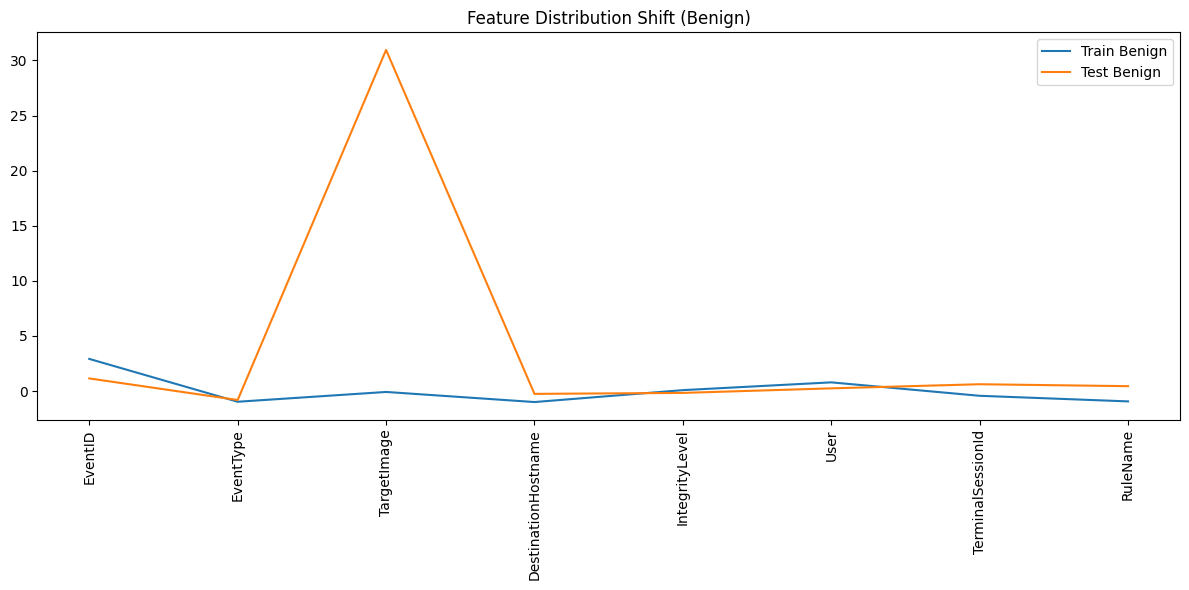

/opt/anaconda3/envs/alibidetect/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Test chunk 1: 14044 samples, benign: 7022, malware: 7022
Test chunk 2: 14044 samples, benign: 7022, malware: 7022
Test chunk 3: 14044 samples, benign: 7022, malware: 7022
Test chunk 4: 14042 samples, benign: 7021, malware: 7021
Test chunk 5: 14042 samples, benign: 7021, malware: 7021
Test chunk 6: 14042 samples, benign: 7021, malware: 7021
Test chunk 7: 14042 samples, benign: 7021, malware: 7021
Test chunk 8: 14042 samples, benign: 7021, malware: 7021
Test chunk 9: 14042 samples, benign: 7021, malware: 7021
Test chunk 10: 14042 samples, benign: 7021, malware: 7021
Train chunk 1: 5000 benign samples
Train chunk 2: 5000 benign samples
Train chunk 3: 5000 benign samples
Train chunk 4: 5000 benign samples
Train chunk 5: 5000 benign samples
Train chunk 6: 5000 benign samples
Train chunk 7: 5000 benign samples
Train chunk 8: 5000 benign samples
Train chunk 9: 5000 benign samples
Train chunk 10: 5000 benign samples

Verifying chunk diversity:
Train chunks 1 and 2 similarity: 439.66%
Train chu

In [5]:
ndf, train_df, test_df, ndf2, train_chunks, test_chunks, train_df2, test_df2 = preprocess_data_3(selected_df, selected_df2)

In [6]:
def count_stats(df, outlier=1, label=1):
    tmp = df.apply(lambda x : True if x['outlier'] == outlier and x['label'] == label else False, axis = 1)
    return len(tmp[tmp == True].index)

def test_model(clf, df):
    X_test = df.drop('label', axis=1)
    outliers_predicted = clf.predict(X_test)
    new_df = df.copy()
    new_df['outlier'] = outliers_predicted
    tp = count_stats(new_df, outlier=-1, label=-1)
    fn = count_stats(new_df, outlier=1, label=-1)
    fp = count_stats(new_df, outlier=-1, label=1)
    tn = count_stats(new_df, outlier=1, label=1)

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2 * (recall * precision) / (precision + recall)
    return new_df, recall, precision, f1, f1, tp, fn, fp, tn

# ISO

### Search best params

In [7]:
import time
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import ParameterGrid
import joblib
import pandas as pd

def evaluate_isolation_forest_parameters(train_df, test_df, test_df2=None):
    """
    Comprehensive parameter selection for Isolation Forest
    """
    
    # Define parameter grid for testing
    param_grid = {
        'n_estimators': [50, 100, 150, 200, 250, 300],
        'contamination': ['auto', 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4],
        'max_samples': ['auto', 0.5, 0.7, 0.8, 1.0],
        'max_features': [0.5, 0.7, 0.8, 1.0],
        'bootstrap': [True, False],
        'random_state': [42]  # For reproducibility
    }
    
    # Quick parameter grid for faster testing
    quick_param_grid = {
        'n_estimators': [50, 100, 200],
        'contamination': ['auto', 0.1, 0.2, 0.3],
        'max_samples': ['auto', 0.8],
        'max_features': [0.8, 1.0],
        'bootstrap': [True, False],
        'random_state': [42]
    }
    
    X_train = train_df.drop('label', axis=1)
    results = []
    
    print("Starting Isolation Forest parameter grid search...")
    print(f"Total combinations to test: {len(list(ParameterGrid(quick_param_grid)))}")
    
    for i, params in enumerate(ParameterGrid(quick_param_grid)):
        try:
            print(f"\nTesting combination {i+1}: {params}")
            
            # Handle max_features parameter
            if isinstance(params['max_features'], float):
                params['max_features'] = int(params['max_features'] * X_train.shape[1])
            
            # Create and train model
            start_train = time.time()
            iso_forest = IsolationForest(**params)
            iso_forest.fit(X_train)
            train_time = time.time() - start_train
            
            # Test on first dataset
            start_test1 = time.time()
            _, recall_1, precision_1, f1_1 = test_model(iso_forest, test_df)
            test1_time = time.time() - start_test1
            
            # Test on second dataset if provided
            if test_df2 is not None:
                start_test2 = time.time()
                _, recall_2, precision_2, f1_2 = test_model(iso_forest, test_df2)
                test2_time = time.time() - start_test2
            else:
                recall_2 = precision_2 = f1_2 = test2_time = 0
            
            # Store results
            result = {
                'params': params,
                'train_time': train_time,
                'test1_precision': precision_1,
                'test1_recall': recall_1,
                'test1_f1': f1_1,
                'test1_time': test1_time,
                'test2_precision': precision_2,
                'test2_recall': recall_2,
                'test2_f1': f1_2,
                'test2_time': test2_time,
                'avg_f1': (f1_1 + f1_2) / 2 if test_df2 is not None else f1_1
            }
            results.append(result)
            
            print(f"Test1 - Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1: {f1_1:.4f}")
            if test_df2 is not None:
                print(f"Test2 - Precision: {precision_2:.4f}, Recall: {recall_2:.4f}, F1: {f1_2:.4f}")
            
        except Exception as e:
            print(f"Error with params {params}: {str(e)}")
            continue
    
    return results

def analyze_isolation_forest_results(results):
    """
    Analyze and display the best parameter combinations for Isolation Forest
    """
    if not results:
        print("No results to analyze!")
        return None
    
    # Convert to DataFrame for easier analysis
    df_results = []
    for result in results:
        row = result['params'].copy()
        row.update({k: v for k, v in result.items() if k != 'params'})
        df_results.append(row)
    
    df = pd.DataFrame(df_results)
    
    print("\n" + "="*80)
    print("ISOLATION FOREST PARAMETER ANALYSIS RESULTS")
    print("="*80)
    
    # Best overall F1 score
    best_idx = df['avg_f1'].idxmax()
    best_result = results[best_idx]
    
    print(f"\nBEST ISOLATION FOREST PARAMETERS (Highest Average F1: {best_result['avg_f1']:.4f}):")
    print("-" * 60)
    for param, value in best_result['params'].items():
        print(f"{param}: {value}")
    
    print(f"\nPerformance:")
    print(f"Test1 - Precision: {best_result['test1_precision']:.4f}, Recall: {best_result['test1_recall']:.4f}, F1: {best_result['test1_f1']:.4f}")
    print(f"Test2 - Precision: {best_result['test2_precision']:.4f}, Recall: {best_result['test2_recall']:.4f}, F1: {best_result['test2_f1']:.4f}")
    print(f"Training time: {best_result['train_time']:.4f}s")
    
    # Top 5 combinations
    print(f"\nTOP 5 ISOLATION FOREST COMBINATIONS:")
    print("-" * 60)
    top_5 = df.nlargest(5, 'avg_f1')
    for i, (idx, row) in enumerate(top_5.iterrows()):
        print(f"\n{i+1}. F1: {row['avg_f1']:.4f}")
        print(f"   n_estimators: {row['n_estimators']}, contamination: {row['contamination']}")
        print(f"   max_samples: {row['max_samples']}, max_features: {row['max_features']}")
        print(f"   bootstrap: {row['bootstrap']}")
    
    # Parameter impact analysis
    print(f"\nISOLATION FOREST PARAMETER IMPACT ANALYSIS:")
    print("-" * 60)
    
    for param in ['n_estimators', 'contamination', 'max_samples', 'max_features', 'bootstrap']:
        if param in df.columns:
            param_analysis = df.groupby(param)['avg_f1'].agg(['mean', 'std', 'count'])
            print(f"\n{param.upper()}:")
            for value, stats in param_analysis.iterrows():
                print(f"  {value}: Mean F1={stats['mean']:.4f} (±{stats['std']:.4f}), Count={stats['count']}")
    
    return best_result

def optimize_isolation_forest(train_df, test_df, test_df2=None):
    """
    Main function to optimize Isolation Forest parameters
    """
    print("Isolation Forest Parameter Optimization")
    print("="*50)
    
    # Run parameter search
    results = evaluate_isolation_forest_parameters(train_df, test_df, test_df2)
    
    # Analyze results
    best_params = analyze_isolation_forest_results(results)
    
    if best_params:
        # Train final model with best parameters
        print(f"\n" + "="*80)
        print("TRAINING FINAL ISOLATION FOREST MODEL WITH BEST PARAMETERS")
        print("="*80)
        
        X_train = train_df.drop('label', axis=1)
        
        # Handle max_features parameter for final model
        final_params = best_params['params'].copy()
        if isinstance(final_params['max_features'], float):
            final_params['max_features'] = int(final_params['max_features'] * X_train.shape[1])
        
        final_iso_forest = IsolationForest(**final_params)
        final_iso_forest.fit(X_train)
        
        # Save the best model
        joblib.dump(final_iso_forest, 'isolation_forest_optimized.joblib')
        print("Best Isolation Forest model saved as 'isolation_forest_optimized.joblib'")
        
        return final_iso_forest, best_params
    
    return None, None

def get_isolation_forest_suggestions():
    """
    Returns suggested parameter combinations for Isolation Forest based on common practices
    """
    suggestions = {
        'default_balanced': {
            'n_estimators': 100,
            'contamination': 'auto',
            'max_samples': 'auto',
            'max_features': 1.0,
            'bootstrap': False,
            'random_state': 42
        },
        'high_precision': {
            'n_estimators': 200,
            'contamination': 0.05,
            'max_samples': 0.8,
            'max_features': 0.8,
            'bootstrap': True,
            'random_state': 42
        },
        'high_recall': {
            'n_estimators': 150,
            'contamination': 0.3,
            'max_samples': 'auto',
            'max_features': 1.0,
            'bootstrap': False,
            'random_state': 42
        },
        'fast_training': {
            'n_estimators': 50,
            'contamination': 'auto',
            'max_samples': 0.5,
            'max_features': 0.7,
            'bootstrap': True,
            'random_state': 42
        },
        'large_dataset': {
            'n_estimators': 100,
            'contamination': 0.1,
            'max_samples': 0.3,
            'max_features': 0.8,
            'bootstrap': True,
            'random_state': 42
        }
    }
    
    print("ISOLATION FOREST PARAMETER SUGGESTIONS:")
    print("="*50)
    for config_type, params in suggestions.items():
        print(f"\n{config_type.upper().replace('_', ' ')}:")
        for param, value in params.items():
            print(f"  {param}: {value}")
    
    return suggestions

def test_isolation_forest_combinations(train_df, test_df, test_df2=None):
    """
    Test specific Isolation Forest parameter combinations
    """
    test_combinations = [
        {'n_estimators': 100, 'contamination': 'auto', 'max_samples': 'auto', 'max_features': 1.0, 'bootstrap': False},
        {'n_estimators': 200, 'contamination': 0.1, 'max_samples': 0.8, 'max_features': 0.8, 'bootstrap': True},
        {'n_estimators': 150, 'contamination': 0.2, 'max_samples': 0.7, 'max_features': 0.9, 'bootstrap': False},
        {'n_estimators': 50, 'contamination': 0.3, 'max_samples': 0.5, 'max_features': 0.7, 'bootstrap': True},
    ]
    
    X_train = train_df.drop('label', axis=1)
    
    print("TESTING ISOLATION FOREST COMBINATIONS:")
    print("="*50)
    
    for i, params in enumerate(test_combinations, 1):
        print(f"\nCombination {i}: {params}")
        
        # Handle max_features parameter
        test_params = params.copy()
        test_params['random_state'] = 42
        if isinstance(test_params['max_features'], float):
            test_params['max_features'] = int(test_params['max_features'] * X_train.shape[1])
        
        try:
            # Train model
            iso_forest = IsolationForest(**test_params)
            iso_forest.fit(X_train)
            
            # Test on datasets
            _, recall_1, precision_1, f1_1 = test_model(iso_forest, test_df)
            print(f"Test1 - Precision: {precision_1:.4f}, Recall: {recall_1:.4f}, F1: {f1_1:.4f}")
            
            if test_df2 is not None:
                _, recall_2, precision_2, f1_2 = test_model(iso_forest, test_df2)
                print(f"Test2 - Precision: {precision_2:.4f}, Recall: {recall_2:.4f}, F1: {f1_2:.4f}")
                print(f"Average F1: {(f1_1 + f1_2) / 2:.4f}")
            
        except Exception as e:
            print(f"Error: {str(e)}")

# Example usage:
if __name__ == "__main__":
    # Method 1: Full optimization (recommended)
    final_model, best_params = optimize_isolation_forest(train_df, test_df, test_df2)
    
    # Method 2: Quick suggestions
    suggestions = get_isolation_forest_suggestions()
    
    # Method 3: Test specific combinations
    test_isolation_forest_combinations(train_df, test_df, test_df2)
    
    pass

Isolation Forest Parameter Optimization
Starting Isolation Forest parameter grid search...
Total combinations to test: 96

Testing combination 1: {'bootstrap': True, 'contamination': 'auto', 'max_features': 0.8, 'max_samples': 'auto', 'n_estimators': 50, 'random_state': 42}
Error with params {'bootstrap': True, 'contamination': 'auto', 'max_features': 15, 'max_samples': 'auto', 'n_estimators': 50, 'random_state': 42}: too many values to unpack (expected 4)

Testing combination 2: {'bootstrap': True, 'contamination': 'auto', 'max_features': 0.8, 'max_samples': 'auto', 'n_estimators': 100, 'random_state': 42}
Error with params {'bootstrap': True, 'contamination': 'auto', 'max_features': 15, 'max_samples': 'auto', 'n_estimators': 100, 'random_state': 42}: too many values to unpack (expected 4)

Testing combination 3: {'bootstrap': True, 'contamination': 'auto', 'max_features': 0.8, 'max_samples': 'auto', 'n_estimators': 200, 'random_state': 42}
Error with params {'bootstrap': True, 'conta

KeyboardInterrupt: 

### Real ISO

Data training:
Precision: 0.815, Recall: 0.755, F1-score: 0.784
Time exe: 0.2284
Data testing:
Precision: 0.500, Recall: 1.000, F1-score: 0.667
Time exe: 2.4472


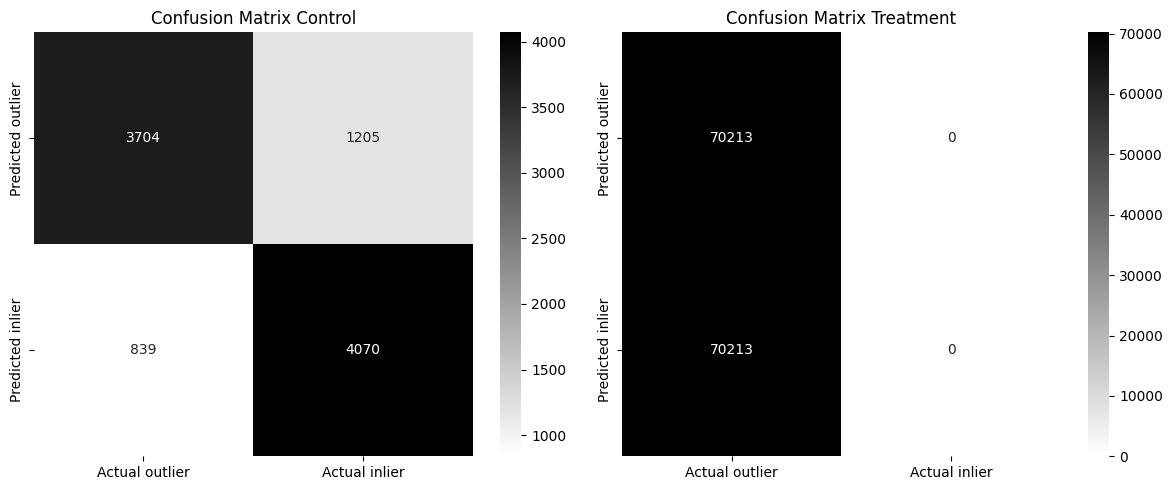

In [8]:
from sklearn.ensemble import IsolationForest
import joblib
import time

X_train = train_df.drop('label', axis=1)
iso = IsolationForest(bootstrap= True,
        contamination=0.2,
        max_features=1.0,
        max_samples=0.7,
        n_estimators=150,
        random_state=42)
iso.fit(X_train)
joblib.dump(iso, 'iso.joblib')

iso = joblib.load('iso.joblib')
start = time.time()
_, recall, precision, f1, f1, tp, fn, fp, tn = test_model(iso, test_df)
end = time.time()
elapsed = end-start

print('Data training:')
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")
print(f'Time exe: {elapsed:.4f}')

start = time.time()
_, recall_2, precision_2, f1_2, f1_2, tp_2, fn_2, fp_2, tn_2 = test_model(iso, test_df2)
end = time.time()
elapsed = end-start
# y_pred_iso = iso.predict(test_df2)

print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f'Time exe: {elapsed:.4f}')

conf_matrix = pd.DataFrame(
    [[tp, fn],
    [fp, tn]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

conf_matrix_2 = pd.DataFrame(
    [[tp_2, fn_2],
    [fp_2, tn_2]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='gray_r', ax=axs[0])
axs[0].set_title("Confusion Matrix Control")
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='gray_r', ax=axs[1])
axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.savefig("comparison_heatmaps.png")
plt.show()

# Retraining

### a. Concat old + new data

Data training:
Precision: 0.783, Recall: 0.685, F1-score: 0.731
Time exe: 0.3023
Data testing:
Precision: 0.795, Recall: 0.921, F1-score: 0.853
Time exe: 3.8485


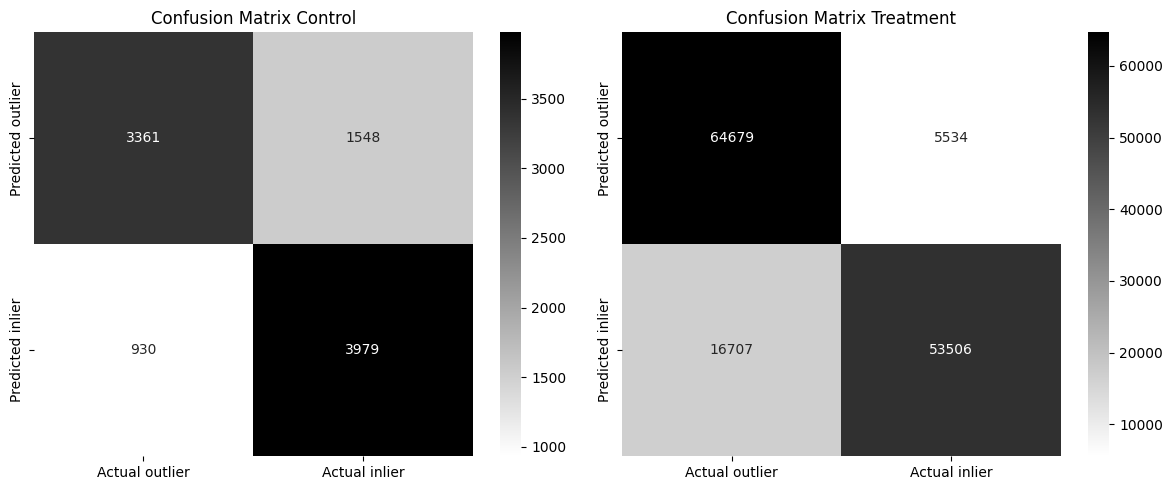

In [9]:
retrain_df = pd.concat([train_df2.iloc[:train_df.shape[0], :], train_df])
X_train = retrain_df.drop('label', axis=1)
iso = IsolationForest(bootstrap= True,
        contamination=0.2,
        max_features=1.0,
        max_samples=0.7,
        n_estimators=150,
        random_state=42)
iso.fit(X_train)
joblib.dump(iso, 'isoretrain.joblib')

iso = joblib.load('isoretrain.joblib')
start = time.time()
_, recall, precision, f1, f1, tp, fn, fp, tn = test_model(iso, test_df)
end = time.time()
elapsed = end-start

print('Data training:')
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")
print(f'Time exe: {elapsed:.4f}')

start = time.time()
_, recall_2, precision_2, f1_, f1_2, tp_2, fn_2, fp_2, tn_2 = test_model(iso, test_df2)
end = time.time()
elapsed = end-start

print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f'Time exe: {elapsed:.4f}')

conf_matrix = pd.DataFrame(
    [[tp, fn],
    [fp, tn]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

conf_matrix_2 = pd.DataFrame(
    [[tp_2, fn_2],
    [fp_2, tn_2]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='gray_r', ax=axs[0])
axs[0].set_title("Confusion Matrix Control")
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='gray_r', ax=axs[1])
axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.show()

### b. Full model replacement with new data

Data testing:
Precision: 0.798, Recall: 0.983, F1-score: 0.881
Time execution: 3.6682


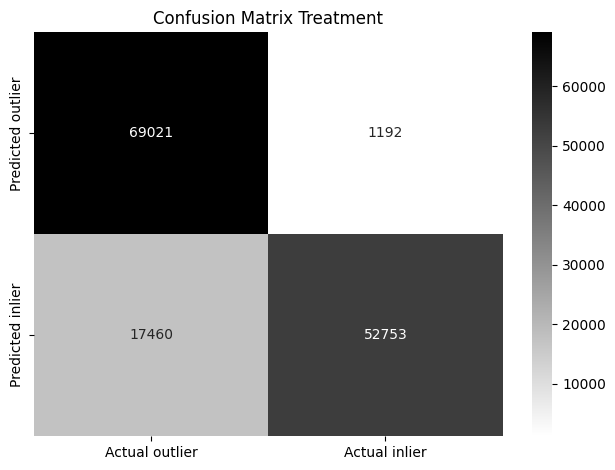

In [10]:
X_train = train_df2.drop('label', axis=1)
iso = IsolationForest(bootstrap= True,
        contamination=0.2,
        max_features=1.0,
        max_samples=0.7,
        n_estimators=150,
        random_state=42)
iso.fit(X_train)

start = time.time()
_, recall_2, precision_2, f1_2, f1_2, tp_2, fn_2, fp_2, tn_2 = test_model(iso, test_df2)
end = time.time()
elapsed = end-start

print('Data testing:')
print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
print(f"Time execution: {elapsed:.4f}")


conf_matrix_2 = pd.DataFrame(
    [[tp_2, fn_2],
    [fp_2, tn_2]],
    columns=['Actual outlier', 'Actual inlier'],
    index=['Predicted outlier', 'Predicted inlier']
)

fig, axs= plt.subplots()
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='gray_r', ax=axs)
axs.set_title("Confusion Matrix Treatment")
# sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='gray_r', ax=axs[1])
# axs[1].set_title("Confusion Matrix Treatment")

plt.tight_layout()
plt.show()

### Continuous retraining

In [11]:
from statsmodels.stats.contingency_tables import mcnemar
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
import joblib

previous_results = None

for i in range(10):
    print(f'Data testing {i+1}:')
    
    training_data = train_chunks[i][train_chunks[i]['label'] == 1].copy()
    print(f"Training on {len(training_data)} samples")
    
    X_train = training_data.drop('label', axis=1)
    iso = IsolationForest(bootstrap= True,
        contamination=0.2,
        max_features=1.0,
        max_samples=0.7,
        n_estimators=150,
        random_state=42)
    iso.fit(X_train)
    joblib.dump(iso, f'isoretrain{i+1}.joblib')
    
    iso = joblib.load(f'isoretrain{i+1}.joblib')
    
    test_data = test_chunks[i].copy()
    print(f"Testing on {len(test_data)} samples")
    
    start = time.time()
    current_results, recall_2, precision_2, f1_2 = test_model(iso, test_data)
    end = time.time()
    elapsed = end-start
    print(f"Precision: {precision_2:.3f}, Recall: {recall_2:.3f}, F1-score: {f1_2:.3f}")
    print(f"Time execution: {elapsed:.4f}")

    
    if previous_results is not None:
        print("\n--- McNemar Test Analysis ---")
        
        if 'outlier' in current_results.columns and 'outlier' in previous_results.columns:
            both_anomaly = len(current_results[
                (current_results['outlier'] == -1) & 
                (previous_results['outlier'] == -1)
            ])
            
            curr_anom_prev_norm = len(current_results[
                (current_results['outlier'] == -1) & 
                (previous_results['outlier'] == 1)
            ])
            
            curr_norm_prev_anom = len(current_results[
                (current_results['outlier'] == 1) & 
                (previous_results['outlier'] == -1)
            ])
            
            both_normal = len(current_results[
                (current_results['outlier'] == 1) & 
                (previous_results['outlier'] == 1)
            ])
            
            print(f"Agreement - Both anomaly: {both_anomaly}")
            print(f"Agreement - Both normal: {both_normal}")
            print(f"Disagreement - Current anomaly, Previous normal: {curr_anom_prev_norm}")
            print(f"Disagreement - Current normal, Previous anomaly: {curr_norm_prev_anom}")
            
            total_disagreements = curr_anom_prev_norm + curr_norm_prev_anom
            total_samples = both_anomaly + both_normal + total_disagreements
            agreement_rate = (both_anomaly + both_normal) / total_samples
            
            print(f"Total disagreements: {total_disagreements}")
            print(f"Agreement rate: {agreement_rate:.3f}")
            
            if total_disagreements > 0:
                mcnemar_table = np.array([
                    [both_anomaly, curr_anom_prev_norm], 
                    [curr_norm_prev_anom, both_normal]
                ])
                
                print(f"McNemar Table:")
                print(f"                Previous Model")
                print(f"               Anomaly  Normal")
                print(f"Current Anomaly   {both_anomaly:4d}    {curr_anom_prev_norm:4d}")
                print(f"        Normal    {curr_norm_prev_anom:4d}    {both_normal:4d}")
                
                try:
                    result = mcnemar(mcnemar_table, exact=False, correction=True)
                    print(f"McNemar Statistic: {result.statistic:.4f}")
                    print(f"McNemar p-value: {result.pvalue}")
                    
                    if result.pvalue < 0.001:
                        print("*** Highly significant difference between models (p < 0.001)")
                    elif result.pvalue < 0.01:
                        print("** Significant difference between models (p < 0.01)")
                    elif result.pvalue < 0.05:
                        print("* Marginally significant difference between models (p < 0.05)")
                    else:
                        print("No significant difference between models (p >= 0.05)")
                        
                except Exception as e:
                    print(f"Error in McNemar test: {e}")
            else:
                print("No disagreements between models - McNemar test not applicable")
        else:
            print("Missing 'outlier' column in results - cannot perform McNemar test")
    elif previous_results is not None:
        print(f"Warning: Result sizes don't match - Current: {len(current_results)}, Previous: {len(previous_results)}")
    else:
        print("First iteration - no previous model to compare")
    
    previous_results = current_results.copy()
    
    print("-" * 80)
    print()

print("Model retraining and comparison completed!")

Data testing 1:
Training on 5000 samples
Testing on 14044 samples
Precision: 0.743, Recall: 0.550, F1-score: 0.632
Time execution: 0.2546
First iteration - no previous model to compare
--------------------------------------------------------------------------------

Data testing 2:
Training on 5000 samples
Testing on 14044 samples
Precision: 0.783, Recall: 0.704, F1-score: 0.742
Time execution: 0.2867

--- McNemar Test Analysis ---
Agreement - Both anomaly: 2357
Agreement - Both normal: 4894
Disagreement - Current anomaly, Previous normal: 3958
Disagreement - Current normal, Previous anomaly: 2835
Total disagreements: 6793
Agreement rate: 0.516
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   2357    3958
        Normal    2835    4894
McNemar Statistic: 185.3208
McNemar p-value: 3.340189788022523e-42
*** Highly significant difference between models (p < 0.001)
--------------------------------------------------------------------------------

/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_27407/4235678592.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_anomaly = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_27407/4235678592.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curr_anom_prev_norm = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_27407/4235678592.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  curr_norm_prev_anom = len(current_results[
/var/folders/88/psn_rp490gg_sfbw5c2mx3dh0000gn/T/ipykernel_27407/4235678592.py:57: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_normal = len(current_results[


Testing on 14042 samples
Precision: 0.804, Recall: 0.864, F1-score: 0.833
Time execution: 0.2590

--- McNemar Test Analysis ---
Agreement - Both anomaly: 2925
Agreement - Both normal: 3985
Disagreement - Current anomaly, Previous normal: 4622
Disagreement - Current normal, Previous anomaly: 2510
Total disagreements: 7132
Agreement rate: 0.492
McNemar Table:
                Previous Model
               Anomaly  Normal
Current Anomaly   2925    4622
        Normal    2510    3985
McNemar Statistic: 624.8347
McNemar p-value: 6.641046050693224e-138
*** Highly significant difference between models (p < 0.001)
--------------------------------------------------------------------------------

Data testing 6:
Training on 5000 samples
Testing on 14042 samples
Precision: 0.792, Recall: 0.739, F1-score: 0.765
Time execution: 0.2511

--- McNemar Test Analysis ---
Agreement - Both anomaly: 3550
Agreement - Both normal: 3499
Disagreement - Current anomaly, Previous normal: 2996
Disagreement - Curren